In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from scipy import stats

data=pd.read_csv('BTC-USD.csv',parse_dates=["Date"],sep=',')

#convert dates from string to datetime objects
data["Date"]=pd.to_datetime(data["Date"])

#keep only the date part of datetime object
data["Date"]=data["Date"].dt.date

#drop the nan values
data.isna().sum()
data.dropna(axis=0,how='any',inplace=True)
data.isna().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [26]:
data['Time_dummy']=np.arange(len(data.index))
data['Time_dummy']=data['Time_dummy'].astype('float64')
data['Change']=data["Close"].pct_change().fillna(0)
data.reset_index(drop=True,inplace=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume,Time_dummy,Change
0,2016-12-13,780.646973,788.460022,777.961975,780.556030,780.556030,8.164560e+07,0.0,0.000000
1,2016-12-14,780.005005,782.033997,776.838989,781.481018,781.481018,7.597900e+07,1.0,0.001185
2,2016-12-15,780.070007,781.434998,777.802002,778.088013,778.088013,8.158010e+07,2.0,-0.004342
3,2016-12-16,778.963013,785.031982,778.963013,784.906982,784.906982,8.360820e+07,3.0,0.008764
4,2016-12-17,785.166016,792.508972,784.864014,790.828979,790.828979,7.898980e+07,4.0,0.007545
...,...,...,...,...,...,...,...,...,...
1818,2021-09-12,50450.082030,50797.164060,47358.351560,47672.121090,47672.121090,2.960358e+10,1818.0,-0.056087
1819,2021-10-12,47642.144530,50015.253910,47023.699220,47243.304690,47243.304690,3.096601e+10,1819.0,-0.008995
1820,2021-11-12,47264.632810,49458.210940,46942.347660,49362.507810,49362.507810,2.577587e+10,1820.0,0.044857
1821,2021-12-12,49354.855470,50724.867190,48725.851560,50098.335940,50098.335940,2.193922e+10,1821.0,0.014907


In [27]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [28]:
stationarity_test=adfuller(data['Change'])
print(stationarity_test)

(-43.798215377190324, 0.0, 0, 1822, {'1%': -3.4339441475744668, '5%': -2.8631276157416945, '10%': -2.5676151930364455}, -6300.154499173412)


Βλέπουμε ότι η σειρά είναι στάσιμη αφού ο έλεγχος Dickey-Fuller έχει σαν 
Hο: Η σειρά δεν είναι στάσιμη
H1: Η σειρά είναι στάσιμη

Για τιμή στατιστικού ελέγχου του τεστ -43.79 και κριτική τιμή -3.43 απορρίπτουμε την Ho. 
Αρα η σειρά μας είναι στάσιμη και μπορούμε να συνεχίσουμε με το υπόδειγμα

<AxesSubplot:>

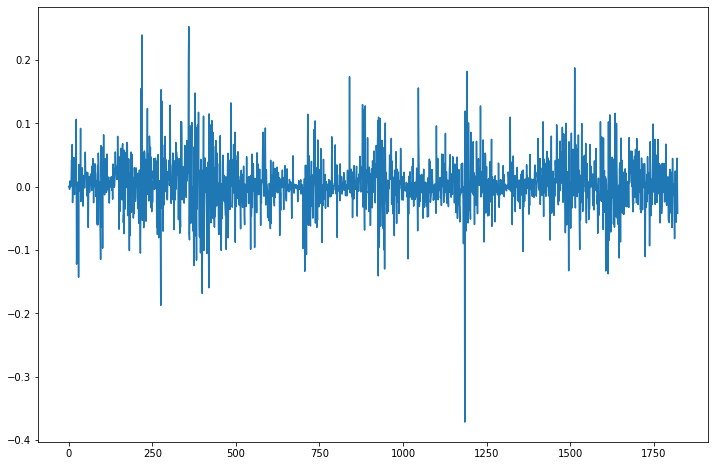

In [29]:
data['Change'].plot(figsize=(12,8))

c:\Users\pchrk\OneDrive\Desktop\cs\3rd\ml\ml-env\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


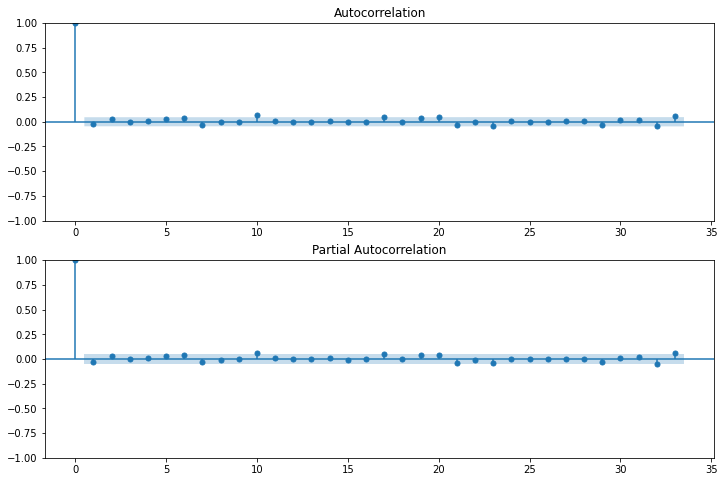

In [30]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(data['Change'],ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(data['Change'],ax=ax2)




In [31]:
y=data[['Date','Change']]

In [32]:
ma_order1_model=ARIMA(y['Change'],order=(0,0,1)).fit()
ma_order1_model.params

const     0.003147
ma.L1    -0.025853
sigma2    0.001757
dtype: float64

In [33]:
print("Akaike information criterion is: ",ma_order1_model.aic,"\n Bayesian Information Criterion is:", ma_order1_model.bic)

Akaike information criterion is:  -6385.747102998936 
 Bayesian Information Criterion is: -6369.2223866749


In [34]:
ma_order2_model=ARIMA(endog=y['Change'],order=(0,0,2)).fit()
ma_order2_model.params

const     0.003146
ma.L1    -0.026215
ma.L2     0.028245
sigma2    0.001756
dtype: float64

In [35]:
print("Akaike information criterion is: ",ma_order2_model.aic,"\n Bayesian Information Criterion is:", ma_order2_model.bic)

Akaike information criterion is:  -6385.231953750455 
 Bayesian Information Criterion is: -6363.198998651741


Εφαρμόζουμε έλεγχο Durbin Watson για να ελέγξουμε την υπαρξη αυτοσυσχέτισης σε lag=1 των καταλοίπων .
Ho:Δεν υφίσταται αυτοσυσχέτιση σε lag=1 για τα κατάλοιπα
H1:Yφίσταται αυτοσυσχέτιση σε lag=1 για τα κατάλοιπα

In [36]:
sm.stats.durbin_watson(ma_order1_model.resid.values)

1.9994173897106415

In [37]:
sm.stats.durbin_watson(ma_order2_model.resid.values)

1.998591701776766

Οι κριτικές τιμές για N=1700 και k=1 είναι [1.886,1.888] επομένως για επίπεδο σημαντικότητας 1% απορρίπτουμε την Hο
Οι κριτικές τιμές για N=1700 και k=1 είναι [1.918,1.923] επομένως για επίπεδο σημαντικότητας 5% απορρίπτουμε την Hο

**Υπάρχει αυτοσυσχέτιση στα κατάλοιπα!** 



In [38]:
residuals_1=ma_order1_model.resid
stats.normaltest(residuals_1)

NormaltestResult(statistic=257.8231173965622, pvalue=1.0337639991679691e-56)

Ελέγχουμε αν τα κατάλοιπα ακολουθούν την κανονική κατανομή
Ho:Τα κατάλοιπα ακολουθούν κανονική κατανομή
Η1 : Τα κατάλοιπα δεν ακολουθούν κανονική κατανομή

Για pval=7.22e-54 < 1% απορρίπτουμε την Ho 

In [39]:
residuals_2=ma_order2_model.resid
stats.normaltest(residuals_2)

NormaltestResult(statistic=257.26210846858356, pvalue=1.368494148137056e-56)

Ελέγχουμε αν τα κατάλοιπα ακολουθούν την κανονική κατανομή
Ho:Τα κατάλοιπα ακολουθούν κανονική κατανομή
Η1 : Τα κατάλοιπα δεν ακολουθούν κανονική κατανομή

Για pval=9.41e-54 < 1% απορρίπτουμε την Ho 

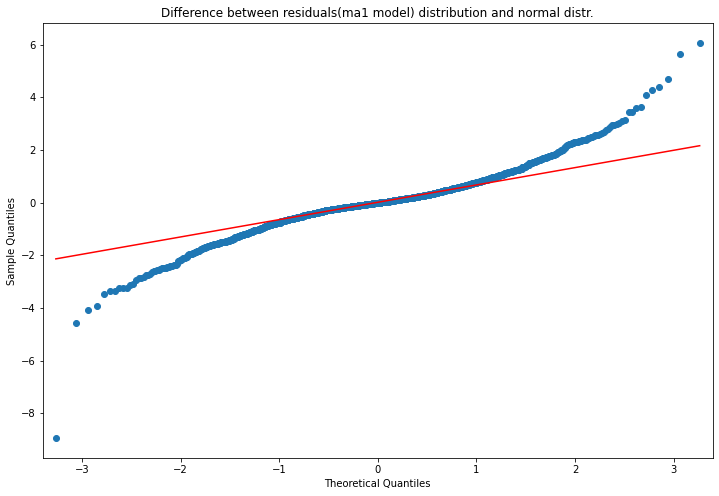

In [40]:
from statsmodels.graphics.api import qqplot

fig3 = plt.figure(figsize=(12, 8))
ax3 = fig3.add_subplot(111)
ax3.set_title("Difference between residuals(ma1 model) distribution and normal distr.")
fig3 = qqplot(residuals_1, line="q", ax=ax3, fit=True)

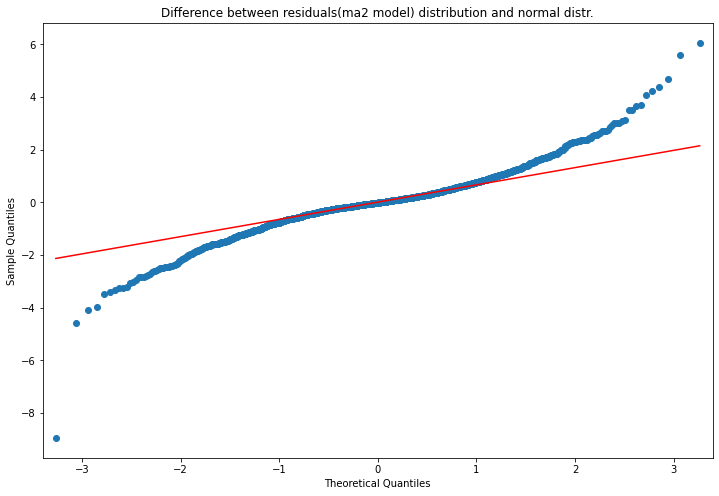

In [41]:
fig4 = plt.figure(figsize=(12, 8))
ax4 = fig4.add_subplot(111)
ax4.set_title("Difference between residuals(ma2 model) distribution and normal distr.")
fig4 = qqplot(residuals_2, line="q", ax=ax4, fit=True)

Από το διάγραμμα βλέπουμε ότι διαφοροποιούνται οι δύο κατανομές ειδικά στα άκρα. Αυτό συμβαίνει γιατί η κατανομή των καταλοίπων προέρχεται από αποδόσεις οικονομικών δεδομένων οι οποίες είναι ιδιαίτερα heavy-tail.

In [42]:
predictions_model1=ma_order1_model.predict(start=1722,end=1821,dynamic=False)
predictions_model1

1722    0.002857
1723    0.003262
1724    0.002295
1725    0.002766
1726    0.006078
          ...   
1817    0.003154
1818    0.003328
1819    0.004683
1820    0.003500
1821    0.002077
Name: predicted_mean, Length: 100, dtype: float64

In [43]:
y['Change'][1722:1822]

1722   -0.001614
1723    0.036216
1724    0.017006
1725   -0.110622
1726   -0.015375
          ...   
1817   -0.003852
1818   -0.056087
1819   -0.008995
1820    0.044857
1821    0.014907
Name: Change, Length: 100, dtype: float64

Ελεγχος προβλεπτικής ικανότητας του μοντέλου μας για τις τελευταίες 100 in-sample παρατηρήσεις

In [44]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# predicting the accuracy score
score=r2_score(y['Change'][1722:1822],predictions_model1)
print('r2 score is: ', score)
print('mean s error is   ',mean_squared_error(y['Change'][1722:1822],predictions_model1))
print('root mean squared error is==',np.sqrt(mean_squared_error(y['Change'][1722:1822],predictions_model1)))

r2 score is:  -0.010272330590491263
mean s error is    0.0012897558754156246
root mean squared error is== 0.03591317133609374


In [45]:
predictions_model2=ma_order2_model.predict(start=1722,end=1821,dynamic=True)
# predicting the accuracy score
score=r2_score(y['Change'][1722:1822],predictions_model1)
print('r2 score is: ', score)
print('mean s error is   ',mean_squared_error(y['Change'][1722:1822],predictions_model2))
print('root mean squared error is==',np.sqrt(mean_squared_error(y['Change'][1722:1822],predictions_model2)))

r2 score is:  -0.010272330590491263
mean s error is    0.0012826391044605625
root mean squared error is== 0.03581395125451201


Παρατηρούμε πως το μοντέλο μας δεν έχει ικανοποιητική προβλεπτική ισχύ